In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix
from pathlib import Path
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D, SeparableConv2D

In [2]:
# importing the data and identifying our labels

def load_images(data):
    images = []
    labels = data[:,1]

    for img_dir in data[:,0]:
        img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_shape)

        images.append(img)
    return (np.array(images), np.array(labels, dtype=np.int32))



DATASET_DIR = "./dataset/chest_xray2/"

# path to the train, test and validation directories.
train_dir = Path(DATASET_DIR + "train")
test_dir = Path(DATASET_DIR + "test")
val_dir = Path(DATASET_DIR + "val")

dirs = [train_dir, test_dir, val_dir]

# the labels for our data. the images are sorted into folders with the label as
#   the folder name in the directory.
labels = {"normal": 0, "opacity": 1}

# list to store the subdirectories(named after their labels) containing the images. 
X = []

img_shape = (150, 150)

for dir in dirs:
    data = []
    for label in labels:
        imgs = (dir / label).glob("*.jpeg")

        for img_dir in imgs:
            data.append([str(img_dir.absolute()), labels[label]])
    X.append(np.array(data))

In [3]:
X_train, y_train = load_images(X[0])
X_test, y_test = load_images(X[1])
X_val, y_val = load_images(X[2])

X_imgs = [X_train, X_test, X_val]
labels = {"normal": 0, "pneumonia": 1}

print(f"Amount of training data: {X_train.shape}")
print(f"Amount of testing data: {X_test.shape}")
print(f"Amount of validation data: {X_val.shape}")

# visualizing how much training data we really have for each label
X_train[0]


Amount of training data: (4192, 150, 150)
Amount of testing data: (624, 150, 150)
Amount of validation data: (1040, 150, 150)


array([[ 23,  18,  15, ...,  94,  98,  94],
       [ 23,  20,  17, ...,  93,  94,  94],
       [ 20,  21,  19, ...,  93,  92,  93],
       ...,
       [ 28,  29,  27, ...,  38,  41,  39],
       [ 30,  29,  28, ...,  66,  64,  65],
       [ 40,  42,  43, ..., 101, 100, 101]], dtype=uint8)

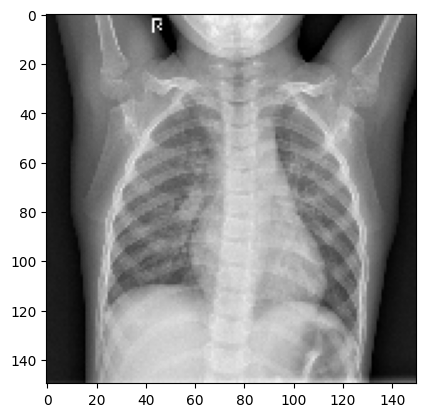

In [4]:
plt.imshow(X_train[0], cmap='gray')

In [5]:
# normalization

X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
X_val = np.array(X_val) / 255.0

X_train = X_train.reshape(-1, img_shape[0], img_shape[1], 1)
X_test = X_test.reshape(-1, img_shape[0], img_shape[1], 1)
X_val = X_val.reshape(-1, img_shape[0], img_shape[1], 1)

# pd.DataFrame(X[0])

In [6]:
# augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.4,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
)

datagen.fit(X_train)
# according to the doc, to use this we run datagen.flow() when we fit the model
# (check ImageDataGenerator above)

In [7]:
# hyperparameters

epochs = 20

In [11]:
model = keras.models.Sequential()

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(150,150,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.15, min_lr=0.000001)
training = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = epochs, validation_data = datagen.flow(X_val, y_val) ,callbacks = [lr_reduction])


print(f"LOSS: {model.evaluate(X_test, y_test)[0]}")
print(f"ACCURACY: {model.evaluate(X_test, y_test)[1] * 100}%")

model.save("./saved_models/model23.keras")
tf.saved_model.save(model, "./saved_models/model23")


# Simplest model i came up with. performing the best so far. got accuracy bn 88-92.4,
# but it seems to fluctuate a bit
# could add more epochs or early stopping or sth to get the best out of it

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                      

INFO:tensorflow:Assets written to: ./saved_models/model23\assets


INFO:tensorflow:Assets written to: ./saved_models/model23\assets


In [9]:
model = keras.models.Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape =(150,150,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (4,4), activation='relu', padding = 'same' ,))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.35, min_lr=0.000001)
training = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = epochs, validation_data = datagen.flow(X_val, y_val) ,callbacks = [lr_reduction])


print(f"LOSS: {model.evaluate(X_test, y_test)[0]}")
print(f"ACCURACY: {model.evaluate(X_test, y_test)[1] * 100}%")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                      

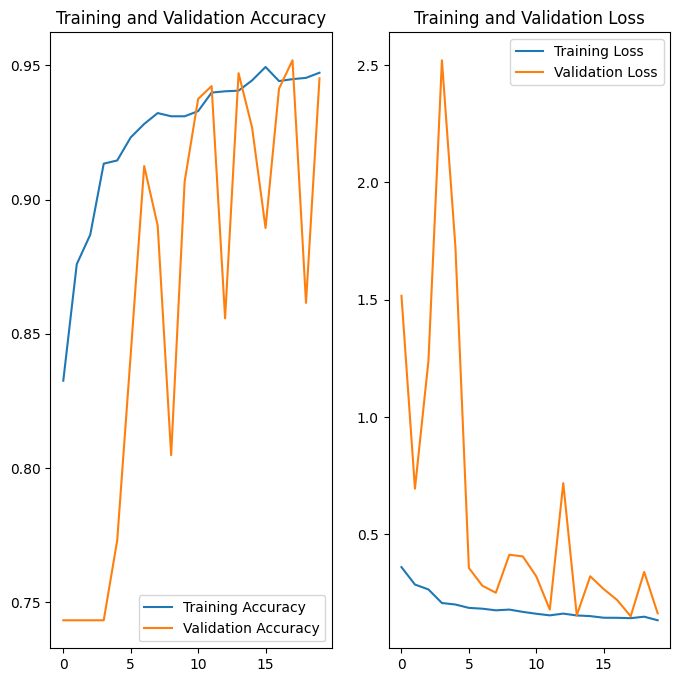

In [10]:
# testing accuracy in output of cell above

acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()